## Preparing the target distribution of the MCMC Algorithms

Preparing the dataset of Gaussian Mixture Model with 2 components.  

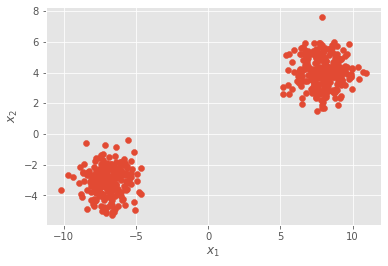

In [1]:
from MCMC_DianZhang.Dian_BayesianInference.Dian_BayesianInference.GMM_datagen import Data_params_gen_GMM
import matplotlib.pyplot as plt

GMM_data_2D_2com = Data_params_gen_GMM(n_components=2, n_dimensions=2)
_,_ = GMM_data_2D_2com.generate(datasize=500)

with plt.style.context("ggplot"):
    plt.scatter(GMM_data_2D_2com.noisy_Dataset[:, 0], GMM_data_2D_2com.noisy_Dataset[:, 1])
    plt.xlabel("$x_1$")

    plt.ylabel("$x_2$")
    plt.show()

Defining the Likelihood function with the dataset generated above.  

In [2]:
from MCMC_DianZhang.Dian_BayesianInference.Dian_BayesianInference.log_Likeli_GMM import Likeli_GMM_mus

GMM_Likeli_2D_2com = Likeli_GMM_mus(Dataset=GMM_data_2D_2com.noisy_Dataset, Sigmas=GMM_data_2D_2com.Sigmas, weights=GMM_data_2D_2com.weights, n_components=GMM_data_2D_2com.n_components)

## Apply the MCMC Algorithm

In [3]:
from MCMC_DianZhang.Dian_MCMC.MetropolisHastingMCMC.MHMC import MHMC
from MCMC_DianZhang.Dian_MCMC.MetropolisHastingMCMC.ProposalDistributions import  GaussianProposalDistribution
steps = 10000
Prop_G = GaussianProposalDistribution(sd=0.10, Dim=GMM_Likeli_2D_2com.n_dimensions*GMM_Likeli_2D_2com.n_components)
MHMC_GMM_2D_2com = MHMC(rho=GMM_Likeli_2D_2com.calculate_log_likelihoods, log_likelihood=True)
Res_G = MHMC_GMM_2D_2com.generate(
    theta0=[0 for _ in range(GMM_Likeli_2D_2com.n_dimensions*GMM_Likeli_2D_2com.n_components)], 
    qProb=Prop_G.log_qProb, 
    qSamp=Prop_G.qSample, 
    steps=steps,
    OutputRunTime=100
    )

In [4]:
from MCMC_DianZhang.Dian_MCMC.MetropolisHastingMCMC.ProposalDistributions import HamiltonianProposalDistribution

steps = 10000
Prop_H = HamiltonianProposalDistribution(rho = GMM_Likeli_2D_2com.calculate_log_likelihoods, epsilon=0.01, L=5, log_likelihood=True)
MHMC_GMM_2D_2com_H = MHMC(rho=Prop_H.U, log_likelihood=True)
Res_H = MHMC_GMM_2D_2com_H.generate(
    theta0=[0 for _ in range(GMM_Likeli_2D_2com.n_dimensions*GMM_Likeli_2D_2com.n_components)], 
    qProb=Prop_H.log_qProb, 
    qSamp=Prop_H.qSample, 
    steps=steps,
    OutputRunTime=100
)

## Visualize the output of the MCMC Algorithm

In [6]:
Res = Res_G

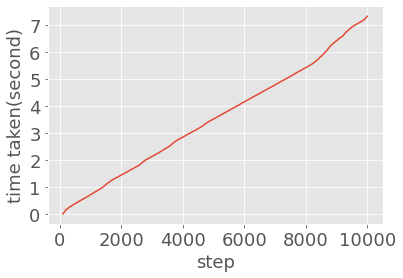

In [7]:
with plt.style.context("ggplot"):
    plt.plot([100*i for i in range(1, int(steps/100)+1)], Res["Run_Times"])
    plt.ylabel("time taken(second)", fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlabel("step", fontsize=18)
    plt.xticks(fontsize=18)
    plt.show()

The acceptance rate of the MCMC algorithm = 0.203


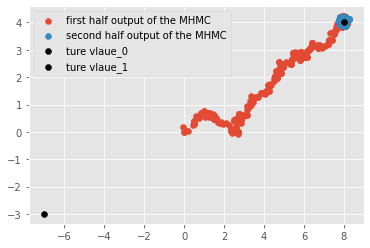

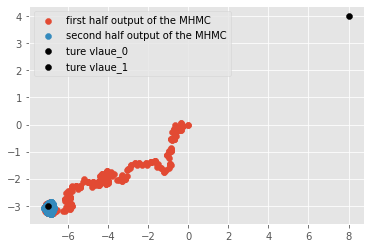

In [8]:
import numpy as np

print(f"The acceptance rate of the MCMC algorithm = {Res['Acceptance_Rate']:.3f}")
with plt.style.context("ggplot"):
    for i in range(GMM_Likeli_2D_2com.n_components):
        plt.scatter(Res["Thetas"][:steps//2, i*2], Res["Thetas"][:steps//2, i*2+1], label="first half output of the MHMC")
        plt.scatter(Res["Thetas"][steps//2:, i*2], Res["Thetas"][steps//2:, i*2+1], label="second half output of the MHMC")

        for j in range(GMM_Likeli_2D_2com.n_components):
            plt.scatter(GMM_data_2D_2com.mus[j][0], GMM_data_2D_2com.mus[j][1], label=f"ture vlaue_{j}", color="black")
        plt.legend()
        plt.show()

In [74]:
import plotly.graph_objects as go

def density_plot_3D(Thetas, bins, x_axis=0, y_axis=1, x_name="x", y_name="y", burn_in=0, credible_region=95, figsize=(800, 800)):
    """
    Plot an interactive 3D heatmap of a pair of dimensions from the input data.

    Arguments:
    Thetas (np.array): the value of parameters generated by the MCMC model
    bins (int): the number of bins of each histogram and heat map
    x_axis (int): the index of the x-axis to plot
    y_axis (int): the index of the y-axis to plot
    x_name (string): the name of the x-axis to plot
    y_name (string): the name of the y-axis to plot
    burn_in (int): the number of the data points want to "burn_in" for the graph
    credible_region (float): the size of the credible region in percent
    figsize (tuple): the size of the figure

    Returns:
    None
    """
    Thetas = np.asarray(Thetas)

    # prepare the data for the 2D histogram
    hist, xedges, yedges = np.histogram2d(Thetas[burn_in:, x_axis], Thetas[burn_in:, y_axis], bins=bins)
    xmid = 0.5*(xedges[1:] + xedges[:-1])
    ymid = 0.5*(yedges[1:] + yedges[:-1])
    X, Y = np.meshgrid(xmid, ymid)

    if (credible_region):
        datasize = Thetas.shape[0]
        credible_value = credible_region*datasize-burn_in
        # create mask for credible region
        cr_mask = np.zeros_like(hist)
        posts_prob = 0
        posts = hist.copy()
        max_pos_idx = np.argmax(posts)
        max_x = int(max_pos_idx//bins)
        max_y = int(max_pos_idx%bins)
        posts_prob += posts[max_x, max_y]
        posts[max_x, max_y] = -1
        cr_mask[max_x, max_y] = 1
        max_hist = hist[max_x, max_y]
        # marking the bins inside the credible region
        while(posts_prob<credible_value):
            max_pos_idx = np.argmax(posts)
            max_x = int(max_pos_idx//bins)
            max_y = int(max_pos_idx%bins)
            posts_prob += posts[max_x, max_y]
            posts[max_x, max_y] = -1
            cr_mask[max_x, max_y] = 1
        del posts
        # ploting the density plot of the inputed data
        fig = go.Figure(data=[go.Surface(x=X, y=Y, z=hist.T, surfacecolor=cr_mask.T, colorscale="Viridis")])
        # create 3D heatmap with the data prepared above
        fig.update_layout(
            title=f"3D density plot of {x_name} and {y_name} with credible region {credible_region}",
            autosize=False,
            width=figsize[0],
            height=figsize[1],
            scene=dict(
                xaxis_title=x_name,
                yaxis_title=y_name,
                zaxis_title="counts",
                aspectratio=dict(x=1, y=1, z=0.7),
                camera_eye=dict(x=-1.7, y=-1.7, z=0.5),
                dragmode="orbit",
                ),
        )
    else:
        # ploting the density plot of the inputed data
        fig = go.Figure(data=[go.Surface(x=X, y=Y, z=hist.T , colorscale="Viridis")])
        # create 3D heatmap with the data prepared above
        fig.update_layout(
            title=f"3D density plot of {x_name} and {y_name}",
            autosize=False,
            width=figsize[0],
            height=figsize[1],
            scene=dict(
                xaxis_title=x_name,
                yaxis_title=y_name,
                zaxis_title="counts",
                aspectratio=dict(x=1, y=1, z=0.7),
                camera_eye=dict(x=-1.7, y=-1.7, z=0.5),
                dragmode="orbit",
                ),
        )
    fig.show()

for cr in [0, 0.3, 0.9]:
    density_plot_3D(Res["Thetas"], bins=50, burn_in=2500, credible_region=cr)

In [51]:
def density_plot_3D(Thetas, bins, x_axis=0, y_axis=1, x_name="x", y_name="y", burn_in=0, credible_region=95, figsize=(600, 600)):

    Thetas = np.asarray(Thetas)

    # prepare the data for the 2D histogram
    hist, xedges, yedges = np.histogram2d(Thetas[burn_in:, x_axis], Thetas[burn_in:, y_axis], bins=bins)
    xmid = 0.5*(xedges[1:] + xedges[:-1])
    ymid = 0.5*(yedges[1:] + yedges[:-1])
    X, Y = np.meshgrid(xmid, ymid)

    if (credible_region):
        datasize = Thetas.shape[0]
        credible_value = credible_region*datasize-burn_in
        # create mask for credible region
        cr_mask = np.zeros_like(hist)
        posts_prob = 0
        posts = hist.copy()
        max_pos_idx = np.argmax(posts)
        max_x = int(max_pos_idx//bins)
        max_y = int(max_pos_idx%bins)
        posts_prob += posts[max_x, max_y]
        posts[max_x, max_y] = -1
        cr_mask[max_x, max_y] = 1
        max_hist = hist[max_x, max_y]
        # marking the bins inside the credible region
        while(posts_prob<credible_value):
            max_pos_idx = np.argmax(posts)
            max_x = int(max_pos_idx//bins)
            max_y = int(max_pos_idx%bins)
            posts_prob += posts[max_x, max_y]
            posts[max_x, max_y] = -1
            cr_mask[max_x, max_y] = 1
        # ploting the density plot of the inputed data
        del posts
        hist[cr_mask==1] = max_hist
        fig = go.Figure(data=[go.Surface(x=X, y=Y, z=hist.T, colorscale="blues")])
        # create 3D heatmap with the data prepared above
        fig.update_layout(
            title=f"3D density plot of {x_name} and {y_name} with credible region {credible_region}",
            autosize=False,
            width=figsize[0],
            height=figsize[1],
            scene=dict(
                xaxis_title=x_name,
                yaxis_title=y_name,
                zaxis_title="counts",
                aspectratio=dict(x=1, y=1, z=0.7),
                camera_eye=dict(x=-1.7, y=-1.7, z=0.5),
                dragmode="orbit",
                ),
        )
    else:
        # ploting the density plot of the inputed data
        fig = go.Figure(data=[go.Surface(x=X, y=Y, z=hist.T , colorscale="blues")])
        # create 3D heatmap with the data prepared above
        fig.update_layout(
            title=f"3D density plot of {x_name} and {y_name}",
            autosize=False,
            width=figsize[0],
            height=figsize[1],
            scene=dict(
                xaxis_title=x_name,
                yaxis_title=y_name,
                zaxis_title="counts",
                aspectratio=dict(x=1, y=1, z=0.7),
                camera_eye=dict(x=-1.7, y=-1.7, z=0.5),
                dragmode="orbit",
                ),
        )
    fig.show()

In [29]:
from matplotlib.patches import Rectangle


def densities_plot(Thetas, plot_axis, bins, burn_in, cr_1D=0, mark_highest_density=False, figsize=(10, 9), cmap='viridis'):
    """
    Plot the density of each axis and the heat map of each pair of axis    

    Arguments
    ---------
    Thetas (np.array): the value of parameters generated by the MCMC model
    plot_axis (List[int]): the axis plotted by the function
    bins (int): the number of bins of each histogram and heat map
    burn_in (int): the number of the data points want to "burn_in" for the graph
    cr_1D (float): the credible region of each 1D density histgram
    figsize: the figure size of the plots
    cmap: the color map used for the 2D histogram

    Returns
    -------
    None
    """

    if not(plot_axis):
        plot_axis = [i for i in range(Thetas.shape[1])]
    n_axis = len(plot_axis)
    datasize = Thetas.shape[0]
    CR_1D = {}

    with plt.style.context("ggplot"):

        fig, axes = plt.subplots(ncols=n_axis, nrows=n_axis, figsize=figsize)
        for i in range(0,n_axis):
            for j in range(0, i+1):
                if i==j:
                    cs, bs, patches = axes[i, j].hist(Thetas[burn_in:, plot_axis[i]], bins=bins)
                    axes[i, j].set_xlabel(f"$x_{plot_axis[i]}$")
                    axes[i, j].set_ylabel("Counts")
                    max_count_idx = np.argmax(cs)
                    bin_center = (bs[max_count_idx] + bs[max_count_idx+1]) / 2
                    if mark_highest_density:    
                        axes[i, j].plot([bin_center, bin_center], [0, cs[max_count_idx]], color='blue', linestyle='--')
                    axes[i, j].set_title("$argmax_{x}$(Counts)"+f" = {np.round(bin_center, 3)}", fontsize=10)
                    if cr_1D>0:
                        CR_1D[i] = []
                        posterior_prob = 0
                        posts = cs/(datasize-burn_in)

                        while(posterior_prob<cr_1D):
                            max_pos_idx = np.argmax(posts)
                            posterior_prob += posts[max_pos_idx]
                            posts[max_pos_idx] = -1
                            CR_1D[i].append(bs[max_pos_idx:max_pos_idx+2])
                            patches[max_pos_idx].set_facecolor("steelblue")

                else:
                    hist = axes[i, j].hist2d(Thetas[burn_in:, plot_axis[j]], Thetas[burn_in:, plot_axis[i]], bins=bins, cmap=cmap)
                    axes[i, j].set_xlabel(f"$x_{plot_axis[j]}$")
                    axes[i, j].set_ylabel(f"$x_{plot_axis[i]}$")
                    fig.delaxes(axes[j, i])

        # Add colorbar to the whole plot
        cbar_ax = fig.add_axes([0.95, (1/n_axis)*1.1, 0.02, 1-(1/n_axis)*1.15]) # left, bottom, width, height
        fig.colorbar(hist[3], cax=cbar_ax)

        fig.subplots_adjust(right=0.85, wspace=0.3, hspace=0.3)
        fig.tight_layout()
        fig.legend(handles=[Rectangle((0,0),1,1,color="steelblue")], labels=[f"Credible Region = {cr_1D}"], loc="upper center")
    plt.show()
    return CR_1D

/var/folders/sn/xtxyc9q57g94hd9p4mx0nfb80000gn/T/ipykernel_21767/4115606185.py:56: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.

/var/folders/sn/xtxyc9q57g94hd9p4mx0nfb80000gn/T/ipykernel_21767/4115606185.py:63: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.

/var/folders/sn/xtxyc9q57g94hd9p4mx0nfb80000gn/T/ipykernel_21767/4115606185.py:66: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



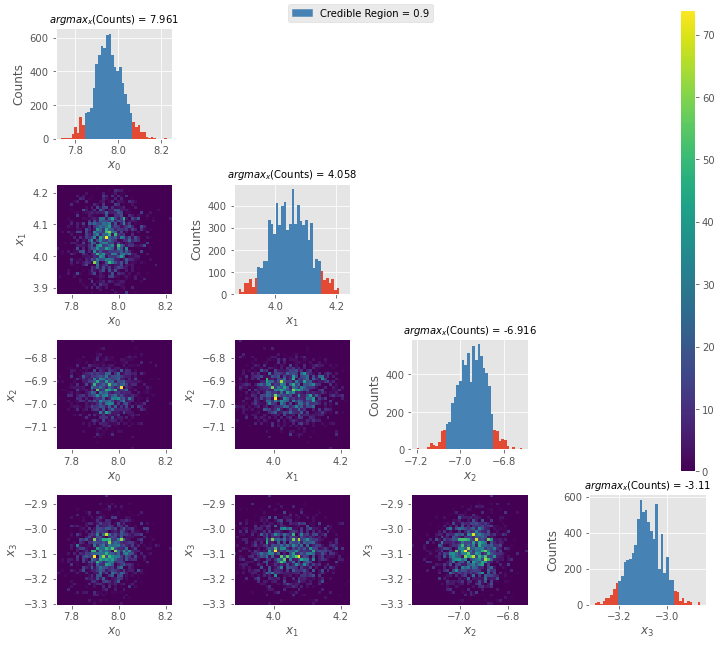

In [23]:
# from MCMC_DianZhang.Dian_MCMC.Statistic_tools import densities_plot

_ = densities_plot(Thetas=Res["Thetas"], plot_axis=[], bins=40, burn_in=2500, cr_1D=0.9)

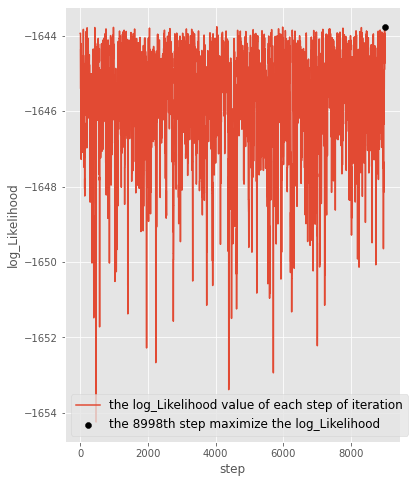

In [25]:
from MCMC_DianZhang.Dian_MCMC.Statistic_tools import targetDis_step_plot
targetDis_step_plot(Thetas=Res["Thetas"][1000:], rho=GMM_Likeli_2D_2com.calculate_log_likelihoods, target_type="log_Likelihood", return_maximum=True)

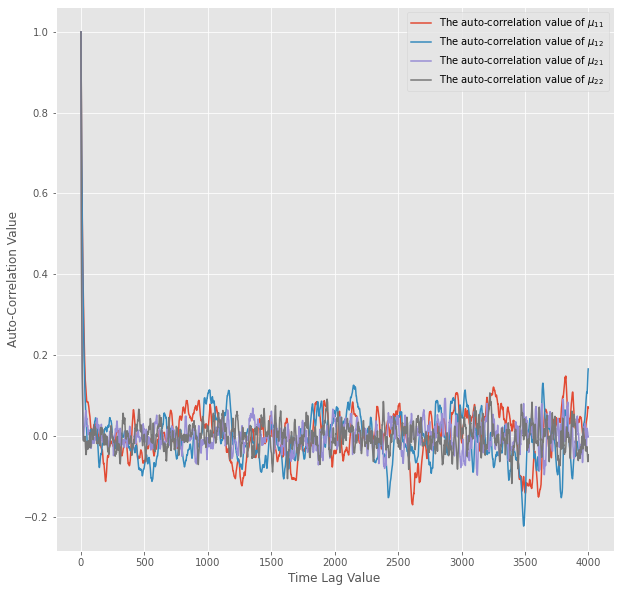

In [29]:
from MCMC_DianZhang.Dian_MCMC.Statistic_tools import auto_corr_plot
auto_corr_plot(Thetas=Res["Thetas"], plot_nth_theta=[0,1,2,3], theta_index=["$\mu_{11}$", "$\mu_{12}$", "$\mu_{21}$", "$\mu_{22}$"], max_time_lag=4000, data_range=[1999,9999])

In [14]:
print(f"The output of the MCMC method which maximize the log likelihood of the parameters is\n {Res['Thetas'][1000+6319][:2]}, {Res['Thetas'][1000+6319][2:]}]")
print(f"The true value of the parameters is {GMM_data_2D_2com.mus}")

The output of the MCMC method which maximize the log likelihood of the parameters is
 [ 5.86345994 -0.83153479], [ 5.12044849 -7.12002597]]
The true value of the parameters is [[ 6 -1]
 [ 5 -7]]


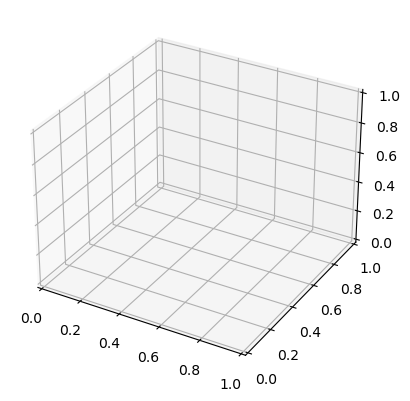

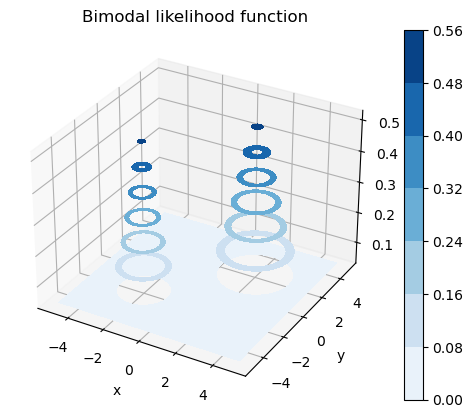

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def log_likelihood(x, y):
    """ 
    A bimodal likelihood function.
    """
    # Define two Gaussian distributions with different means and standard deviations
    mu1 = [2, 2]
    mu2 = [-2, -2]
    cov1 = [[1, 0], [0, 1]]
    cov2 = [[0.5, 0], [0, 0.5]]
    gaussian1 = np.exp(-0.5*np.dot((np.array([x,y])-np.array(mu1)).T,np.dot(np.linalg.inv(cov1),(np.array([x,y])-np.array(mu1)))))
    gaussian2 = np.exp(-0.5*np.dot((np.array([x,y])-np.array(mu2)).T,np.dot(np.linalg.inv(cov2),(np.array([x,y])-np.array(mu2)))))
    # Combine the two Gaussians to create a bimodal distribution
    likelihood = 0.5*gaussian1 + 0.5*gaussian2
    return np.log(likelihood)

# Create a grid of x and y values
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)

# Evaluate the likelihood function at each point in the grid
Z = np.zeros((len(x), len(y)))
for i in range(len(x)):
    for j in range(len(y)):
        Z[i, j] = log_likelihood(x[i], y[j])

# Plot the likelihood function as a contour plot
plt.contourf(X, Y, np.exp(Z), cmap='Blues')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Bimodal likelihood function')
plt.colorbar()
plt.show()
